## Problem 2: Interpolation between images using GAN (24 points)

### (a) Train a GAN on MNIST using class code as starting point.
#### Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.examples.tutorials.mnist import input_data

# Load MNIST data
mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


#### Helper Functions

In [2]:
# Utility Functions
def variables_from_scope(scope_name):
    """
    Returns a list of all trainable variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope_name)

def visualize_row(images, img_dim=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a row
    in a plot, using `cmap` to map from numbers to colors.
    """
    im = np.concatenate(np.reshape(images, [-1,img_dim,img_dim]), 1)
    plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=cmap)
    plt.show()

#### Hyper-params

In [3]:
# Graph parameters
z_dimension = 64
intermediate_layer_size = 128
image_size = 784

# Training parameters
batch_size = 50
iterations = 2000

# Seed for RNG
SEED=12345
np.random.seed(SEED)

#### Generator & Discriminator

In [4]:
# Generator
def generator(z):
    hidden_layer = tf.layers.dense(z, intermediate_layer_size, name="G1", activation=tf.nn.relu)
    fake_X = tf.layers.dense(hidden_layer, image_size, name="G2", activation=tf.sigmoid)
    return fake_X

# Discriminator
def discriminator(x):
    hidden_layer = tf.layers.dense(x, intermediate_layer_size, name="D1", activation=tf.nn.relu)
    D_output = tf.layers.dense(hidden_layer, 1, name="D2",activation=tf.sigmoid)
    return D_output

#### Build Forward Pass

In [5]:
tf.reset_default_graph()

# Placeholders
real_X = tf.placeholder(tf.float32, [None,image_size])
z = tf.placeholder(tf.float32, [None,z_dimension])

# Generator
with tf.variable_scope("generator") as scope:
    fake_X = generator(z)

# Discriminator
#  - be careful because we want these two to share variables
with tf.variable_scope("discriminator") as scope:
    d_on_fake = discriminator(fake_X)
    scope.reuse_variables() # Within this scope, all variables have the same name so reuse them
    d_on_real = discriminator(real_X)
    
# Loss
#  - Generator wants to maximize d_on_fake
g_loss = -tf.reduce_mean(tf.log(d_on_fake))
#  - Discriminator wants to have high output for real images and low output for fake images
d_loss = -tf.reduce_mean(tf.log(d_on_real) + tf.log(1-d_on_fake))

# Optimizer
optimizer = tf.train.AdamOptimizer()
d_step = optimizer.minimize(d_loss, var_list=variables_from_scope("discriminator"))
g_step = optimizer.minimize(g_loss, var_list=variables_from_scope("generator"))

# Initializer
initialize_all = tf.global_variables_initializer()

#### Train GAN

Iter [       0] Time [0.2279] d_loss [1.2587]


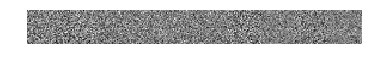

Iter [    1000] Time [3.0341] d_loss [0.0744]


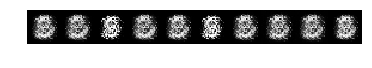

Iter [    1999] Time [5.9669] d_loss [0.2987]


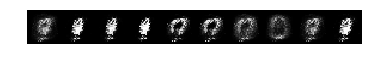

In [6]:
# Train the GAN.

# Create a batch of random samples from z
def make_noise():
    return np.random.uniform(-1.0, 1.0, [batch_size, z_dimension])

# Create feed dictionaries
def next_feed_dict():
    return {real_X: mnist.train.next_batch(batch_size)[0],
            z:      make_noise()}

sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    
    # Run step of generator training
    sess.run(g_step, feed_dict=next_feed_dict())
    
    # Run step of discriminator training
    _, loss = sess.run([d_step, d_loss], feed_dict=next_feed_dict())

    # Every once in a while plot some examples of generated samples
    if t % 1000 == 0 or t+1 == iterations:
        fake_data = sess.run(fake_X, feed_dict={z: make_noise()})
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row(fake_data[:10])

### (b) Generate some images, say 10, by first drawing samples, $\epsilon$, from the simple distribution and then feeding them through the generator.

In [7]:
# Generate 10 fake latent variables
np.random.seed(SEED)
epsilon = np.random.uniform(-1.0, 1.0, [10, z_dimension])

# Forward pass through generator
fake_data = sess.run(fake_X, feed_dict={z: epsilon})

### (c) Visualize the images and pick any two (preferably different digit labels), identify their inputs and set them to $\epsilon_{start}$ and $\epsilon_{end}$

(10, 28, 28)


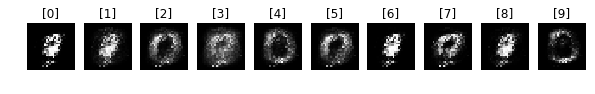

In [8]:
ims = np.reshape(fake_data, [-1,28,28])
print(ims.shape)

plt.figure(figsize=(10,2))
for ind in range(10):
    plt.subplot(1,10,ind+1)
    plt.imshow(ims[ind],cmap='gray')
    plt.title("[{}]".format(ind))
    plt.axis("off")
plt.show()

# index 2 and 8 look good so we will go with them
epsilon_start = epsilon[2]
epsilon_end = epsilon[8]

### (d) Generate 10 steps between $\epsilon_{start}$ and $\epsilon_{end}$ by linear interpolation.

In [9]:
# Linear interpolation between two vectors. Returns a list of length
#  = steps where [0] contains vec_a, [-1] contains vec_b, and the 
#  intermediate values are interpolated.
def get_interpolated_vectors(vec_a,vec_b,steps=10):
    interps = []
    for k in range(steps):
        val = float(1-k/(steps-1.))*vec_a + float(k/(steps-1.))*vec_b
        print("val is {}% vec_a and {}% vec_b".format(100*(1-k/(steps-1.)),100*(k/(steps-1.))))
        interps.append(val)
    return np.array(interps)

# Generate the 10 interpolated values
epsilon_steps = get_interpolated_vectors(epsilon_start, epsilon_end, steps=10)

val is 100.0% vec_a and 0.0% vec_b
val is 88.88888888888889% vec_a and 11.11111111111111% vec_b
val is 77.77777777777779% vec_a and 22.22222222222222% vec_b
val is 66.66666666666667% vec_a and 33.33333333333333% vec_b
val is 55.55555555555556% vec_a and 44.44444444444444% vec_b
val is 44.44444444444444% vec_a and 55.55555555555556% vec_b
val is 33.333333333333336% vec_a and 66.66666666666666% vec_b
val is 22.22222222222222% vec_a and 77.77777777777779% vec_b
val is 11.111111111111116% vec_a and 88.88888888888889% vec_b
val is 0.0% vec_a and 100.0% vec_b


### (e) Generate 10 images using $\epsilon_{start}$ = $\epsilon_{1}$,…, $\epsilon_{10}$ = $\epsilon_{end}$ as inputs to the generator and visualize them.

(10, 64)
(10, 28, 28)


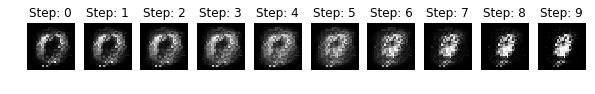

In [10]:
print(epsilon_steps.shape)

# Forward pass through generator
fake_data = sess.run(fake_X, feed_dict={z: epsilon_steps})

# Format as images and plot
ims = np.reshape(fake_data, [-1,28,28])
print(ims.shape)
plt.figure(figsize=(10,2))
for ind in range(10):
    plt.subplot(1,10,ind+1)
    plt.imshow(ims[ind],cmap='gray')
    plt.title("Step: {}".format(ind))
    plt.axis("off")
plt.show()

sess.close()

## Problem 3. Interpolating with variational autoencoders (24 points)

### (a) Train a variational autoencoder on MNIST using class code as starting point.

#### Prelims

In [11]:
# Start fresh
tf.reset_default_graph()

# Import data
mnist = input_data.read_data_sets("../MNIST_data", one_hot=True)

# alias for slim
slim = tf.contrib.slim

# helper for visualizing images
def visualize_row(image, reconstruction, img_width=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a column
    in a plot, using `cmap` to map from numbers to colors.
    """
    fig, ax = plt.subplots(1, 2)
    image = np.reshape(image, [-1, img_width])
    reconstruction = np.reshape(reconstruction, [-1, img_width])
    plt.figure()
    ax[0].imshow(np.clip(image, 0, 1), cmap=cmap)
    ax[0].axis("off")
    ax[0].set_title("Train")
    ax[1].imshow(np.clip(reconstruction, 0, 1), cmap=cmap)
    ax[1].axis("off")
    ax[1].set_title("Generated")
    plt.show()

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


#### VAE Encoder and Decoder

In [12]:
def encoder(x):
    """Network Q(z|x) - made of two FC layers that take the flattened
            image as input and output a vector of length 128. The first
            64 elements of the output vector are interpreted as the mean
            and the last 64 elements are interpreted as the log variance
    """
    mu_logvar = slim.fully_connected(x,128,scope="fc1",activation_fn=tf.nn.relu, weights_initializer=tf.truncated_normal_initializer(0.0,0.1))
    mu_logvar = slim.fully_connected(mu_logvar,128,scope="fc2",activation_fn=None, weights_initializer=tf.truncated_normal_initializer(0.0,0.1))
    return mu_logvar

def decoder(mu_logvar):
    """Network p(x|z) - given the input mean and log variance from
            the encoder network, create an output that should exist
            in p(x)
    """
    # Split off input as mean and log variance
    mu,logvar = tf.split(mu_logvar,num_or_size_splits=2,axis=1)
    
    # Standard deviation must be positive
    stddev = tf.sqrt(tf.exp(logvar))
    
    # Draw a z from the distribution specified by mu logvar. Remember, 
    #  cannot generate the distribution directly because we need to 
    #  be able to compute gradients and random number generation is
    #  not differentiable
    epsilon = tf.random_normal(tf.shape(stddev))
    z = mu + tf.multiply(stddev,epsilon)
    
    # Specify Decoding Network
    x_logits = slim.fully_connected(z,128,scope="fc1",activation_fn=tf.nn.relu, weights_initializer=tf.truncated_normal_initializer(0.0, 0.1))
    x_logits = slim.fully_connected(x_logits,784,scope="fc2",activation_fn=None,weights_initializer=tf.truncated_normal_initializer(0.0, 0.1))
    
    # x_hat to be generated from a Bernoulli distribution
    x_dist = tf.contrib.distributions.Bernoulli(logits=x_logits,dtype=tf.float32)
    
    return x_logits,x_dist

#### Define loss function, optimizer, and trainstep

In [13]:
def optimizer(x_logits, x, mu_logvar):
    """Define reconstruction and KL divergence losses and the optimizer"""
    with tf.variable_scope("optimizer")as scope:
        # Reconstruction Loss
        reconstruction = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=x,logits=x_logits),reduction_indices=[1])
        
        # KL Divergence
        mu,logvar=tf.split(mu_logvar,num_or_size_splits=2,axis=1)
        kl_d = -0.5*tf.reduce_sum(1.0+logvar-tf.square(mu)-tf.exp(logvar),reduction_indices=[1])
        
        # Total Loss
        loss = tf.reduce_mean(reconstruction+kl_d)
        
        # ADAM optimizer
        train_step = tf.train.AdamOptimizer().minimize(loss)
        
    return train_step

#### Build Forward Pass 

In [14]:
# Reset the graph
tf.reset_default_graph()

# Define input placeholder
x = tf.placeholder(tf.float32, [None,784], name='x')

# Define VAE graph
with tf.variable_scope("encoder"):
    mu_logvar = encoder(x)
with tf.variable_scope("decoder"):
    x_logits,x_dist = decoder(mu_logvar)
    x_hat = x_dist.sample()

# Optimization
with tf.variable_scope('unlabeled') as scope:
    train_step_unlabeled = optimizer(x_logits,x,mu_logvar)

#### Train VAE

Iteration 0


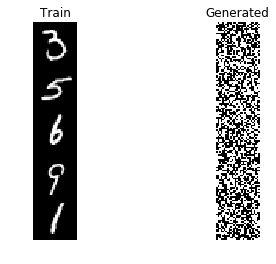

<Figure size 432x288 with 0 Axes>

Iteration 1000


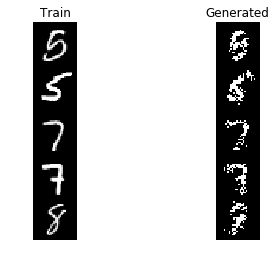

<Figure size 432x288 with 0 Axes>

Iteration 2000


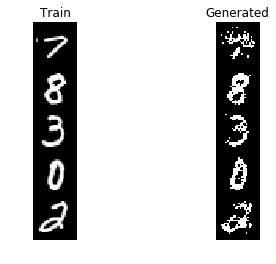

<Figure size 432x288 with 0 Axes>

Iteration 3000


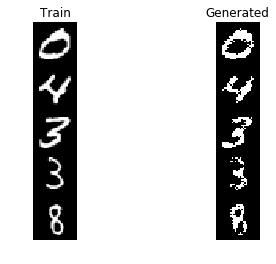

<Figure size 432x288 with 0 Axes>

Iteration 4000


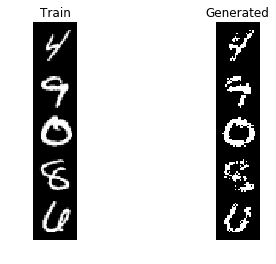

<Figure size 432x288 with 0 Axes>

In [15]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

# Train VAE model
for i in range(5000):
    # Get a training minibatch
    batch = mnist.train.next_batch(100)

    # Binarize the data
    x_binarized = (batch[0]>0.5).astype(np.float32)

    # Train on minibatch
    sess.run(train_step_unlabeled,feed_dict={x:x_binarized})

    # Visualize reconstructions every 1000 iterations
    if i % 1000 == 0:
        batch = mnist.validation.next_batch(5)
        x_binarized = (batch[0]>0.5).astype(np.float32)
        reconstructions=sess.run(x_hat,feed_dict={x:x_binarized})
        print("Iteration {}".format(i))
        visualize_row(batch[0],reconstructions)

### (b) Using the encoder, generate latent representations for 2 images ($z_{start}$ and $z_{end}$) matching the digit labels selected in Problem 2c.

(1, 10)
Shape of Latent Representations: (1, 128)


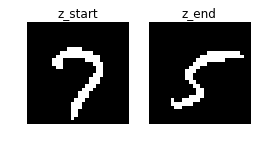

In [16]:
start_class = 7
end_class = 5

# Grab an example of a starting class and end class from dataset
z_start,z_startlbl = mnist.validation.next_batch(1)
print(z_startlbl.shape)
while np.argmax(z_startlbl) != start_class:
    z_start,z_startlbl = mnist.validation.next_batch(1)
z_start = (z_start>0.5).astype(np.float32)

z_end,z_endlbl = mnist.validation.next_batch(1)
while np.argmax(z_endlbl) != end_class:
    z_end,z_endlbl = mnist.validation.next_batch(1)
z_end = (z_end>0.5).astype(np.float32)

# Plot Sample Images
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.imshow(np.reshape(z_start, [-1, 28]),cmap='gray')
plt.title("z_start")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(np.reshape(z_end, [-1, 28]),cmap='gray')
plt.title("z_end")
plt.axis("off")

# Generate Latent Representations
z_start_latent=sess.run(mu_logvar,feed_dict={x:z_start})
z_end_latent=sess.run(mu_logvar,feed_dict={x:z_end})

print("Shape of Latent Representations: {}".format(z_start_latent.shape))

### (c) Generate (via decoding) and visualize images from 10 steps $z_{start}$ = $z_{1}$,…, $z_{10}$ = $z_{end}$ using linear interpolation.

val is 100.0% vec_a and 0.0% vec_b
val is 88.88888888888889% vec_a and 11.11111111111111% vec_b
val is 77.77777777777779% vec_a and 22.22222222222222% vec_b
val is 66.66666666666667% vec_a and 33.33333333333333% vec_b
val is 55.55555555555556% vec_a and 44.44444444444444% vec_b
val is 44.44444444444444% vec_a and 55.55555555555556% vec_b
val is 33.333333333333336% vec_a and 66.66666666666666% vec_b
val is 22.22222222222222% vec_a and 77.77777777777779% vec_b
val is 11.111111111111116% vec_a and 88.88888888888889% vec_b
val is 0.0% vec_a and 100.0% vec_b


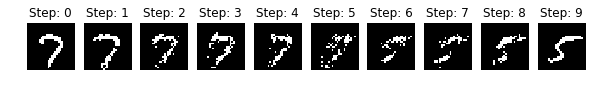

In [18]:
# Get interpolated vectors from z_start to z_end
z_steps = get_interpolated_vectors(z_start_latent, z_end_latent, steps=10)

# Forward pass through generator
z_images=sess.run(x_hat,feed_dict={mu_logvar:z_steps.squeeze()})
z_images[0] = z_start
z_images[-1] = z_end
# Format as images and plot
ims = np.reshape(z_images, [-1,28,28])
plt.figure(figsize=(10,2))
for ind in range(10):
    plt.subplot(1,10,ind+1)
    plt.imshow(np.clip(ims[ind], 0, 1),cmap='gray')
    plt.title("Step: {}".format(ind))
    plt.axis("off")
plt.show()

#sess.close()

### (d) How does the quality of the VAE generated images compare to those from GAN?

### (e) Do you observe any differences in the smoothness of the interpolation from both models?

## Problem 4: Conditioning on class labels (24 points)

### (a) Modify the code from Problem 2 to take as input a vector 10 times larger.

and 

### (b) Modify the code from Problem 2 to take as input the concatenation of $\epsilon$ (random vector) and a one-hot vector encoding of the labels.

#### Prelims

In [49]:
# Start fresh
tf.reset_default_graph()

# Import data
mnist = input_data.read_data_sets("../MNIST_data", one_hot=True)

# Graph parameters
z_dimension = 64
intermediate_layer_size = 128
image_size = 784

# Training parameters
batch_size = 50
iterations = 20000

# Seed for RNG
SEED=12345
np.random.seed(SEED)

def visualize_row_p3(images, conditioners, img_dim=28, cmap='gray'):
    ims = np.reshape(images, [-1,28,28])
    plt.figure(figsize=(10,2))
    for ind in range(len(ims)):
        plt.subplot(1,10,ind+1)
        plt.imshow(ims[ind],cmap='gray')
        plt.title("Cond: {}".format(np.argmax(conditioners[ind])))
        plt.axis("off")
    plt.show()

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


#### Define G and D

In [50]:
# Generator
def generator(z_conditioned):
    hidden_layer = tf.layers.dense(z_conditioned, intermediate_layer_size, name="G1", activation=tf.nn.relu)
    fake_X = tf.layers.dense(hidden_layer, image_size, name="G2", activation=tf.sigmoid)
    return fake_X

# Discriminator
def discriminator(x_conditioned):
    hidden_layer = tf.layers.dense(x_conditioned, intermediate_layer_size, name="D1", activation=tf.nn.relu)
    D_output = tf.layers.dense(hidden_layer, 1, name="D2",activation=tf.sigmoid)
    return D_output

#### Build Forward Pass

In [51]:
# Placeholders
real_X = tf.placeholder(tf.float32, [None,image_size])
z = tf.placeholder(tf.float32, [None,z_dimension])
conditioner = tf.placeholder(tf.float32, [None,10])

real_X_cond = tf.concat([real_X,conditioner],1)
z_cond = tf.concat([z,conditioner],1)

print("real_X_cond.shape ",real_X_cond.shape)
print("z_cond.shape ",z_cond.shape)


# Generator
with tf.variable_scope("generator") as scope:
    fake_X = generator(z_cond)
    fake_X_cond = tf.concat([fake_X,conditioner],1)
    
# Discriminator
#  - be careful because we want these two to share variables
with tf.variable_scope("discriminator") as scope:
    d_on_fake = discriminator(fake_X_cond)
    scope.reuse_variables() # Within this scope, all variables have the same name so reuse them
    d_on_real = discriminator(real_X_cond)
    
# Loss
#  - Generator wants to maximize d_on_fake
g_loss = -tf.reduce_mean(tf.log(d_on_fake))
#  - Discriminator wants to have high output for real images and low output for fake images
d_loss = -tf.reduce_mean(tf.log(d_on_real) + tf.log(1-d_on_fake))

# Optimizer
optimizer = tf.train.AdamOptimizer()
d_step = optimizer.minimize(d_loss, var_list=variables_from_scope("discriminator"))
g_step = optimizer.minimize(g_loss, var_list=variables_from_scope("generator"))

# Initializer
initialize_all = tf.global_variables_initializer()

real_X_cond.shape  (?, 794)
z_cond.shape  (?, 74)


### (c) Train the GAN.

Iter [       0] Time [0.2347] d_loss [1.5989]


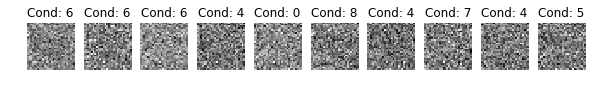

Iter [    1000] Time [3.4649] d_loss [0.1191]


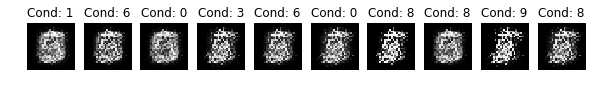

Iter [    2000] Time [6.8929] d_loss [0.0369]


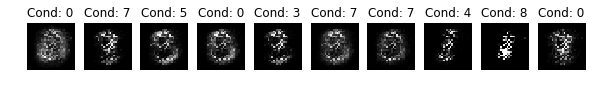

Iter [    3000] Time [10.4184] d_loss [0.1353]


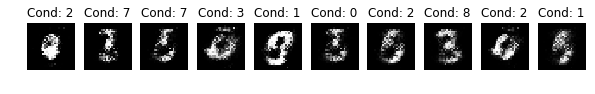

Iter [    4000] Time [14.3985] d_loss [0.1294]


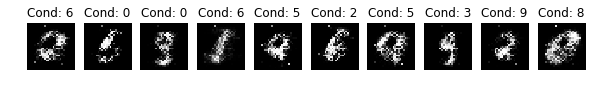

Iter [    5000] Time [18.5754] d_loss [0.2234]


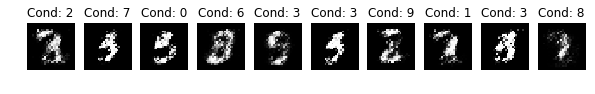

Iter [    6000] Time [22.6149] d_loss [0.3321]


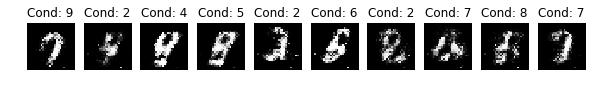

Iter [    7000] Time [26.9189] d_loss [0.6517]


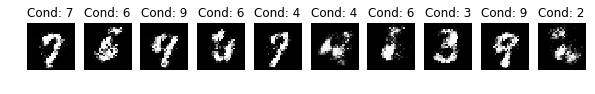

Iter [    8000] Time [31.3567] d_loss [0.4509]


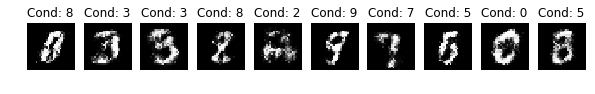

Iter [    9000] Time [35.8433] d_loss [0.6391]


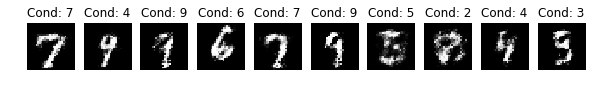

Iter [   10000] Time [40.4224] d_loss [0.8915]


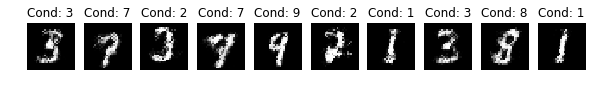

Iter [   11000] Time [44.9161] d_loss [0.7591]


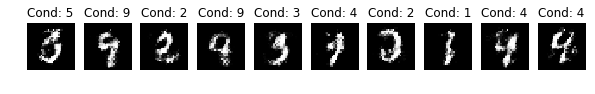

Iter [   12000] Time [49.4877] d_loss [0.4097]


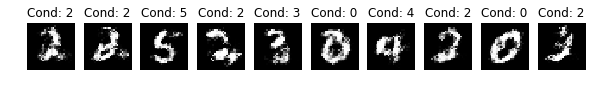

Iter [   13000] Time [54.2869] d_loss [0.7361]


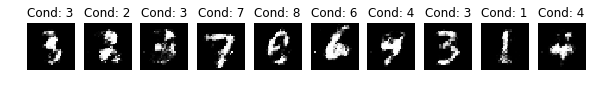

Iter [   14000] Time [58.9947] d_loss [0.7639]


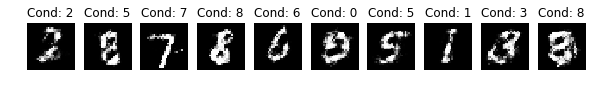

Iter [   15000] Time [63.6430] d_loss [0.6876]


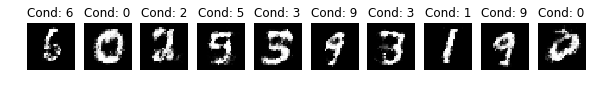

Iter [   16000] Time [68.2792] d_loss [0.6747]


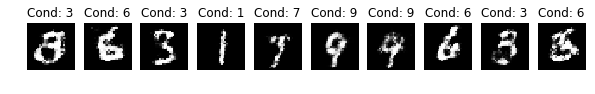

Iter [   17000] Time [72.7308] d_loss [1.2218]


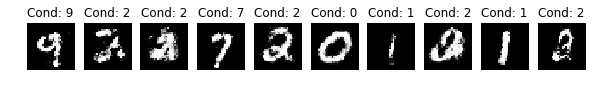

Iter [   18000] Time [77.2378] d_loss [0.7965]


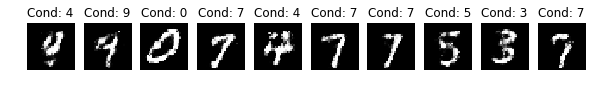

Iter [   19000] Time [81.7172] d_loss [0.9478]


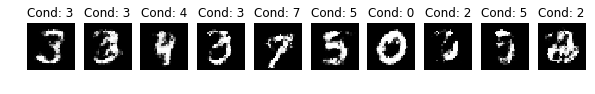

Iter [   19999] Time [86.2709] d_loss [0.6805]


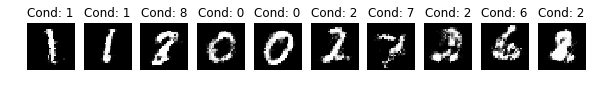

In [52]:
# Create a batch of random samples from z
def make_noise():
    return np.random.uniform(-1.0, 1.0, [batch_size, z_dimension])

def make_random_conditioners():
    return np.eye(10)[np.random.choice(10, batch_size)]

# Create feed dictionaries
def next_feed_dict():
    bat = mnist.train.next_batch(batch_size)
    return {real_X: bat[0],
            conditioner: bat[1],
            z:      make_noise()}

sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    
    # Run step of generator training
    sess.run(g_step, feed_dict=next_feed_dict())
    
    # Run step of discriminator training
    _, loss = sess.run([d_step, d_loss], feed_dict=next_feed_dict())

    # Every once in a while plot some examples of generated samples
    if t % 1000 == 0 or t+1 == iterations:
        conds = make_random_conditioners()
        fake_data = sess.run(fake_X, feed_dict={z: make_noise(), conditioner: conds})
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row_p3(fake_data[:10], conds[:10])

### (d) Generate and visualize 10 images from each digit by setting the labels accordingly as inputs to the generator and $\epsilon$ at random from its distribution.

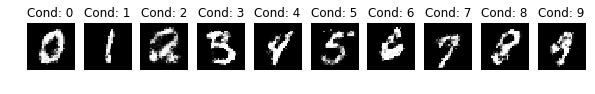

In [53]:
# Create data to push through Generator
sequential_conditions = np.eye(10)
sequential_epsilons = np.random.uniform(-1.0, 1.0, [10, z_dimension])

# Forward pass through G
fake_data = sess.run(fake_X, feed_dict={z: sequential_epsilons, conditioner: sequential_conditions})
visualize_row_p3(fake_data, sequential_conditions)